# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [3]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [4]:
def imshow(img,text,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [34]:
class Config():
    training_dir = "./data/lfiw/lfw-100/train/"
    testing_dir = "./data/lfiw/lfw-100/valid/"
    train_batch_size = 8 #64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [35]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [36]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [37]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
0 indiciates dissimilar, and 1 indicates similar.

In [38]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

TypeError: imshow() missing 1 required positional argument: 'text'

## Neural Net Definition
We will use a standard convolutional neural network

In [27]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [28]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [29]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [30]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [31]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 0.8713765740394592

Epoch number 0
 Current loss 19.16653823852539

Epoch number 0
 Current loss 2.745361089706421

Epoch number 0
 Current loss 10.533676147460938

Epoch number 0
 Current loss 6.748439788818359

Epoch number 0
 Current loss 1.9154592752456665

Epoch number 1
 Current loss 2.0146491527557373

Epoch number 1
 Current loss 2.6612744331359863

Epoch number 1
 Current loss 2.306161880493164

Epoch number 1
 Current loss 0.8476109504699707

Epoch number 1
 Current loss 1.809251308441162

Epoch number 1
 Current loss 1.4560070037841797

Epoch number 2
 Current loss 1.9841545820236206

Epoch number 2
 Current loss 0.6135849356651306

Epoch number 2
 Current loss 0.4424911141395569

Epoch number 2
 Current loss 0.8570263385772705

Epoch number 2
 Current loss 2.45060133934021

Epoch number 2
 Current loss 1.176214337348938

Epoch number 3
 Current loss 1.2287707328796387

Epoch number 3
 Current loss 0.8206112384796143

Epoch number 3
 Current loss

Epoch number 27
 Current loss 1.2493277788162231

Epoch number 27
 Current loss 1.4670981168746948

Epoch number 28
 Current loss 0.9718024730682373

Epoch number 28
 Current loss 1.3506183624267578

Epoch number 28
 Current loss 0.4840504229068756

Epoch number 28
 Current loss 1.1123567819595337

Epoch number 28
 Current loss 1.1566383838653564

Epoch number 28
 Current loss 1.842201590538025

Epoch number 29
 Current loss 0.9676697254180908

Epoch number 29
 Current loss 0.7293197512626648

Epoch number 29
 Current loss 0.7802162766456604

Epoch number 29
 Current loss 1.0983355045318604

Epoch number 29
 Current loss 0.9252209663391113

Epoch number 29
 Current loss 0.7404823303222656

Epoch number 30
 Current loss 1.0461622476577759

Epoch number 30
 Current loss 0.9889087080955505

Epoch number 30
 Current loss 0.8338396549224854

Epoch number 30
 Current loss 0.7523826360702515

Epoch number 30
 Current loss 0.6290544271469116

Epoch number 30
 Current loss 0.6500043272972107

E

Epoch number 55
 Current loss 1.3591784238815308

Epoch number 55
 Current loss 1.121970534324646

Epoch number 55
 Current loss 1.4640709161758423

Epoch number 55
 Current loss 0.8856182098388672

Epoch number 55
 Current loss 1.0074760913848877

Epoch number 56
 Current loss 0.7375388741493225

Epoch number 56
 Current loss 0.83452969789505

Epoch number 56
 Current loss 0.5941141247749329

Epoch number 56
 Current loss 0.7358619570732117

Epoch number 56
 Current loss 1.185192346572876

Epoch number 56
 Current loss 1.1969085931777954

Epoch number 57
 Current loss 0.7961084246635437

Epoch number 57
 Current loss 0.7685888409614563

Epoch number 57
 Current loss 0.9310227036476135

Epoch number 57
 Current loss 0.7319185137748718

Epoch number 57
 Current loss 1.1223015785217285

Epoch number 57
 Current loss 0.8944013714790344

Epoch number 58
 Current loss 1.1545988321304321

Epoch number 58
 Current loss 1.2040057182312012

Epoch number 58
 Current loss 1.0269365310668945

Epoc

Epoch number 82
 Current loss 0.915682315826416

Epoch number 82
 Current loss 0.41196295619010925

Epoch number 82
 Current loss 0.6596626043319702

Epoch number 83
 Current loss 0.27924150228500366

Epoch number 83
 Current loss 0.20174874365329742

Epoch number 83
 Current loss 0.40003183484077454

Epoch number 83
 Current loss 0.22795750200748444

Epoch number 83
 Current loss 0.7167495489120483

Epoch number 83
 Current loss 0.5232707858085632

Epoch number 84
 Current loss 0.14596335589885712

Epoch number 84
 Current loss 0.4198221266269684

Epoch number 84
 Current loss 0.4737292528152466

Epoch number 84
 Current loss 0.4161580204963684

Epoch number 84
 Current loss 0.3283824026584625

Epoch number 84
 Current loss 0.1802864372730255

Epoch number 85
 Current loss 0.4530539810657501

Epoch number 85
 Current loss 0.407201886177063

Epoch number 85
 Current loss 0.282484233379364

Epoch number 85
 Current loss 0.18550918996334076

Epoch number 85
 Current loss 0.27611342072486

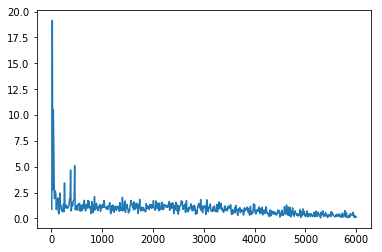

In [32]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

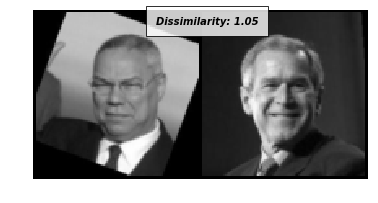

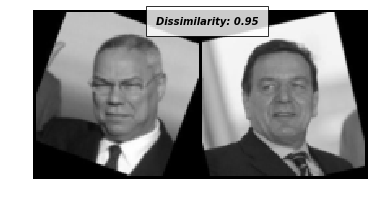

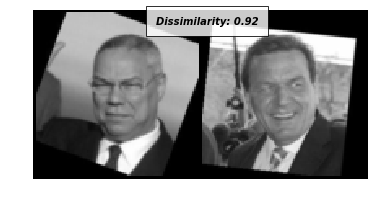

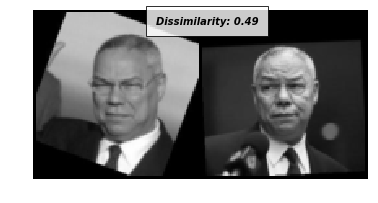

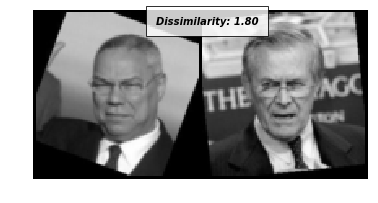

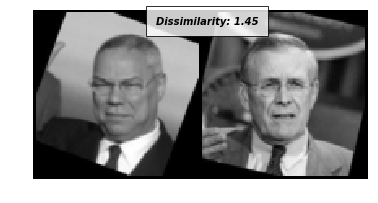

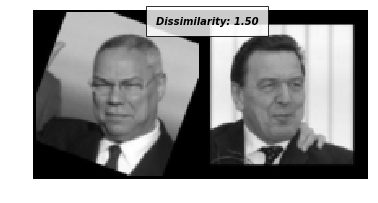

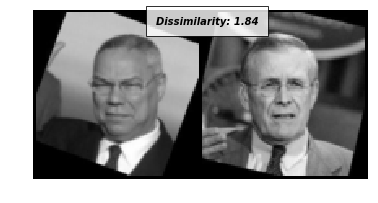

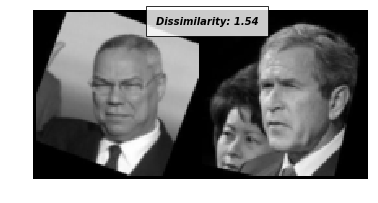

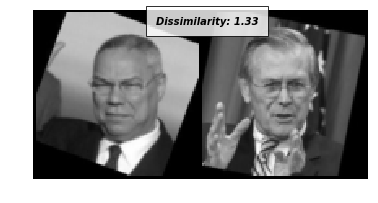

In [39]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))

